In [1]:
import numpy as np
import math #For the factorial
from scipy.integrate import odeint
from scipy.optimize import root
from matplotlib import pyplot as plt
%matplotlib inline

dtype('int32')

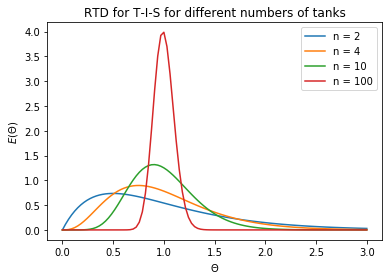

In [2]:
#Plot RTD for tanks in series for dimensionless time
Theta = np.linspace(0, 3, 100)
tanks = np.array([2, 4, 10, 100])
for n in tanks:
    E = n*(n*Theta)**(n-1)/math.factorial(n-1)*np.exp(-n*Theta)
    plt.plot(Theta, E, label = 'n = '+str(n))
plt.legend()
plt.xlabel(r'$\Theta$')
plt.ylabel(r'$E(\Theta)$')
plt.title('RTD for T-I-S for different numbers of tanks')
tanks.dtype

Text(0, 0.5, 'X')

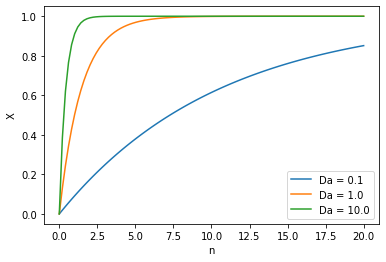

In [3]:
#Plot conversion vs number of tanks for first order reaction
n = np.linspace(0, 20, 100)
Da = np.array([0.1, 1, 10])
for i in Da:
    X = 1-1/(1+i)**n
    plt.plot(n, X, label = 'Da = '+str(i))
plt.legend()
plt.xlabel('n')
plt.ylabel('X')

## Example Problem 18-1
Also includes solution by segregation model and maximum mixedness

In [4]:
#Import reactor data
D = 0.1 #m, diameter
L = 6.36 #m, length
V = D**2*L*np.pi/4*1000. #volume, L
k = 0.25 #1/min, rate constant
#print(V)

### First fit polynomials to the measured RTD so that we can calculate E(t) and F(t)

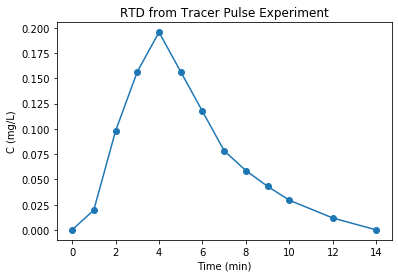

In [12]:
t_tracer = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14])
C_tracer = np.array([0, 1, 5, 8, 10, 8, 6, 4, 3, 2.2, 1.5, 0.6, 0])
A = 51.1 #area under C-curve (From Fogler, Chapter 16)
E_tracer = C_tracer/A
plt.plot(t_tracer, E_tracer, label = 'Experimental Data', marker = 'o')
plt.xlabel('Time (min)')
plt.ylabel('C (mg/L)')
plt.title('RTD from Tracer Pulse Experiment')
t_range = np.linspace(0, 14, 100)

In [13]:
split_point = 5
p1 = np.poly1d(np.polyfit(t_tracer[0:split_point], E_tracer[0:split_point], deg = 3))
p2 = np.poly1d(np.polyfit(t_tracer[split_point:], E_tracer[split_point:], deg = 3))

In [14]:
def polynomial_fit(t):
    E_fitted = np.zeros(len(t))
    
    for i in range(len(t)):
        if t[i] < t_tracer[split_point]:
            E_fitted[i] = p1(t[i])
        elif t[i] >= max(t_tracer):
            E_fitted[i] = 0
        else:
            E_fitted[i] = p2(t[i])
            #Check that E is not negative
        E_fitted[i] = max(E_fitted[i], 0)    

    return E_fitted

In [15]:
polynomial_fit([13.99])
#max(polynomial_fit([13.99]), 0)

array([0.])

Text(0.5, 1.0, 'RTD from Tracer Pulse Experiment')

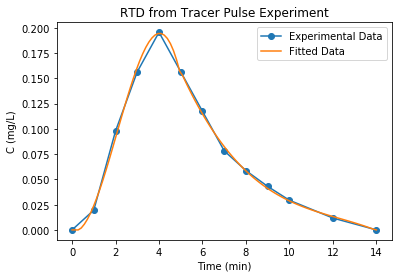

In [16]:
E_fitted = polynomial_fit(t_range)
plt.plot(t_tracer, E_tracer, label = 'Experimental Data', marker = 'o')
plt.plot(t_range, E_fitted, label = 'Fitted Data')
plt.legend()
plt.xlabel('Time (min)')
plt.ylabel('C (mg/L)')
plt.title('RTD from Tracer Pulse Experiment')

Now that we have a fit, calculate $\tau$ and $\sigma^2$

$$\tau = \int_{0}^{\infty}tE(t)dt$$
$$\sigma^2 = \int_{0}^{\infty}(t-\tau)^2E(t)dt$$

In [18]:
#Calculate tau
def tau_deriv(E, t):
    dtaudt = t*polynomial_fit([t]) 
    return dtaudt

tau = 5.125


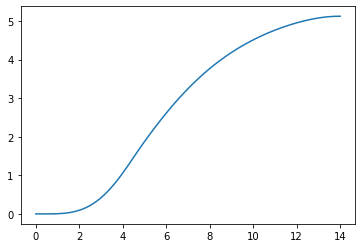

In [19]:
tau_sol = odeint(tau_deriv, 0, t_range)
plt.plot(t_range, tau_sol)
tau = float(max(tau_sol))
print(f'tau = {tau:.3f}')

In [20]:
#Calculate sigma^2
def ss_deriv(E, t):
    dssdt = (t-tau)**2*polynomial_fit([t]) 
    return dssdt

sigma^2 = 6.200


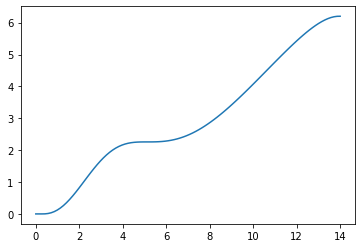

In [21]:
ss_sol = odeint(ss_deriv, 0, t_range)
plt.plot(t_range, ss_sol)
ss = float(max(ss_sol))
print(f'sigma^2 = {ss:.3f}')

Calculate Peclet number from

$$\frac{\sigma^2}{\tau^2}=\frac{2}{Pe}-\frac{2}{Pe^2}(1-e^{-Pe})$$

using a nonlinear equation solver (root). This alogrithm uses optimization to find the roots of a function, so the implement this we define a peclet function as:

$$0=\frac{2}{Pe}-\frac{2}{Pe^2}(1-e^{-Pe})-\frac{\sigma^2}{\tau^2}$$

In [22]:
def peclet(Pe, ss, tau):
    y =  2/Pe - 2/Pe**2*(1-np.exp(-1*Pe))  -ss/tau**2
    return y

In [23]:
Pe_sol =root(peclet, 10, args = (ss, tau))
Pe = float(Pe_sol.x)
print(f'Pe = {float(Pe):.3f}')
print(peclet(Pe, ss, tau))

Pe = 7.316
0.0


In [24]:
Da = tau*k
print(f'Da = {Da:.3f}')

Da = 1.281


In [25]:
q = (1+4*Da/Pe)**0.5
print(f'q = {q:.3f}')

q = 1.304


In [26]:
def conversion(Pe, q):
    X = 1- 4*q*np.exp(Pe/2)/((1+q)**2*np.exp(Pe*q/2)-(1-q)**2*np.exp(-Pe*q/2))
    return X

In [27]:
X_dispersion = conversion(Pe, q)
print(f'X from the dispersion model is {X_dispersion:.3f}')

X from the dispersion model is 0.677


In [28]:
X_PFR = 1-np.exp(-Da)
print(f'X from the PFR model is {X_PFR:.3f}')

X from the PFR model is 0.722


### Tanks-In-Series

In [29]:
n = tau**2/ss
print(n)

4.236475964749618


Note that, for first order, n doesn't have to be an integer!
Conversion for TIS is:
$$X = 1 - \frac{1}{(1+\tau_ik)^n}=1 - \frac{1}{(1+\frac{\tau}{n}k)^n}$$

In [30]:
X_TIS = 1 - 1/(1+tau/n*k)**n
print(f'X from the TIS model is {X_TIS:.3f}')

X from the TIS model is 0.674


How does the RTD look for T-I-S versus the actual?

Text(0, 0.5, 'E(t)')

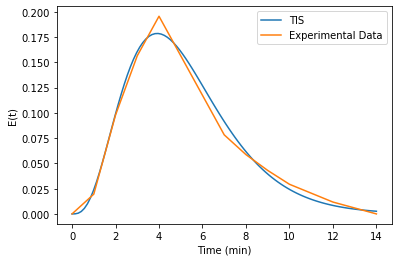

In [31]:
tau_i = tau/n
E_TIS = t_range**(n-1)/(math.gamma(n)*tau_i**n)*np.exp(-t_range/tau_i)
#note that the factorial fucntion can onyl handle integers, whereas gamma can handle nonintegers, and (n-1)! = gamma(n)
plt.plot(t_range, E_TIS, label = 'TIS')
plt.plot(t_tracer, E_tracer, label = 'Experimental Data')
plt.legend()
plt.xlabel('Time (min)')
plt.ylabel('E(t)')

### Single CSTR

In [32]:
X_CSTR = Da/(1+Da)
print(f'X from a single CSTR is {X_CSTR:.3f}')

X from a single CSTR is 0.562


Text(0, 0.5, 'E(t)')

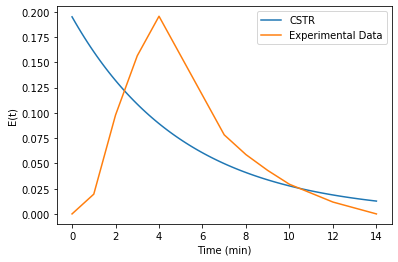

In [33]:
#How does hte RTD for a CSTR compare?
E_CSTR = np.exp(-t_range/tau)/tau
plt.plot(t_range, E_CSTR, label = 'CSTR')
plt.plot(t_tracer, E_tracer, label = 'Experimental Data')
plt.legend()
plt.xlabel('Time (min)')
plt.ylabel('E(t)')

### Segregation Model

In [34]:
def dXbardt(X, t):
    dXbardt = (1-np.exp(-t*k))*polynomial_fit([t])
    return dXbardt

X from segregation model is 0.671


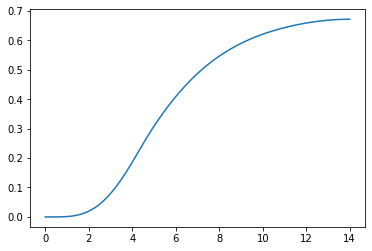

In [35]:
X_bar_sol = odeint(dXbardt, 0, t_range)
plt.plot(t_range, X_bar_sol)
X_seg = float(max(X_bar_sol))
print(f'X from segregation model is {X_seg:.3f}')

### Maximum Mixedness

$$\frac{dX}{dz} = -\frac{r_A}{C_{A0}}-\frac{E(\bar T-z)}{1-F(\bar T-z)}X$$

We need F(t), which is defined as

$$F(t) = \int_{0}^{t}E(t)dt$$

In [36]:
def F_deriv(E, t):
    dFdt = polynomial_fit([t])
    return dFdt

def F(t):
    F = float(max(odeint(F_deriv, 0, np.linspace(0, t, 100))))
    return F

#There are more efficient ways to do this, but this will do for now

In [37]:
Tbar = 13.7
def MM(X,z):
    y = Tbar-z
    E = float(polynomial_fit([y]))
    Ft = F(y)
    dXdz = k*(1-X)-E*X/(1-Ft)
    print(f'z={float(z):.6f}, E={float(E):.3f}, F={float(Ft):.3f}, X = {float(X):.3f}, dXdz={float(dXdz):.3f}')
    return dXdz

z=0.000000, E=0.002, F=0.994, X = 0.000, dXdz=0.250
z=0.000868, E=0.002, F=0.994, X = 0.000, dXdz=0.250
z=13.778540, E=0.000, F=0.000, X = 0.012, dXdz=0.247
z=-0.079054, E=0.001, F=0.994, X = -0.004, dXdz=0.252
z=0.031041, E=0.002, F=0.994, X = 0.000, dXdz=0.250
z=13.732003, E=0.000, F=0.000, X = 0.014, dXdz=0.247
z=-0.052484, E=0.002, F=0.994, X = -0.005, dXdz=0.253
z=0.028139, E=0.002, F=0.994, X = 0.000, dXdz=0.250
z=13.695752, E=0.000, F=0.000, X = 0.524, dXdz=0.119
z=0.006967, E=0.002, F=0.994, X = 0.000, dXdz=0.250
[1.35507324e+248]


C:\Users\benwo\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\benwo\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


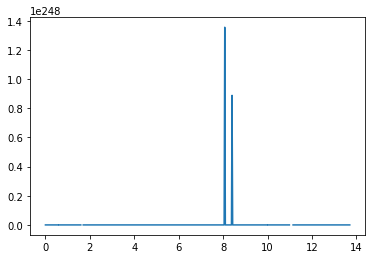

In [38]:
z_range = np.linspace(0, Tbar, 500)
sol2 = odeint(MM, 0, z_range, rtol = 1.0E-2, atol = 1.0E-2)#, h0 = 0.1, hmax = 0.2)
plt.plot(z_range, sol2)
print(max(sol2))